Reading API key from environment
          Dates   Close                   dt
0    2019-01-01   53.13  2019-01-01 00:00:00
1    2019-01-02   55.69  2019-01-02 00:00:00
2    2019-01-03   54.88  2019-01-03 00:00:00
3    2019-01-04   56.91  2019-01-04 00:00:00
4    2019-01-07   58.49  2019-01-07 00:00:00
..          ...     ...                  ...
844  2022-03-28  112.45  2022-03-28 00:00:00
845  2022-03-29  110.45  2022-03-29 00:00:00
846  2022-03-30  113.54  2022-03-30 00:00:00
847  2022-03-31  107.46  2022-03-31 00:00:00
848  2022-04-01  104.53  2022-04-01 00:00:00

[849 rows x 3 columns]


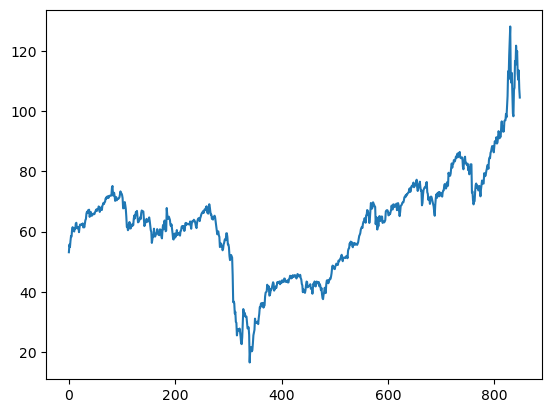

In [1]:
import pandas as pd
import numpy as np
import httpx
import pyarrow as pa
import matplotlib.pyplot as plt
import os

api_url = "https://api.variantperception.com"
if "VP_ANALYSIS_API_KEY" in os.environ:
    print("Reading API key from environment")
    api_key = os.environ.get("VP_ANALYSIS_API_KEY")
else:
    with open(os.path.expanduser("~/vp_api_key.txt"), "r") as file:
        print("Reading API key from file")
        api_key = file.read().replace("\n", "")

df = pd.read_csv('data/BrentOil.csv')
df['dt'] = pd.to_datetime(df.Dates).dt.strftime('%Y-%m-%d %H:%M:%S')
print(df)

plt.plot(df.Close)
plt.show()


In [2]:
requestsHeaders = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json",
}
with httpx.Client(http2=True) as client:
    body = {
        "index": df.dt.to_list(),
        "price": df.Close.to_list()
        #"format": "csv",
    }

    res = client.post(
        api_url + "/api/v1/model/lppl",
        json=body,
        headers=requestsHeaders,
        timeout=600,
    )

    with pa.ipc.open_file(res.content) as reader:
        output = reader.read_pandas()
    
output


,price,signal,bubble_end_p,crash_end_p
dt,,,,
2019-01-01,53.13,NaN,NaN,NaN
2019-01-02,55.69,NaN,NaN,NaN
2019-01-03,54.88,NaN,NaN,NaN
2019-01-04,56.91,NaN,NaN,NaN
2019-01-07,58.49,NaN,NaN,NaN
...,...,...,...,...
2022-05-18,NaN,0.0,0.0,0.0
2022-05-19,NaN,0.0,0.0,0.0
2022-05-20,NaN,0.0,0.0,0.0


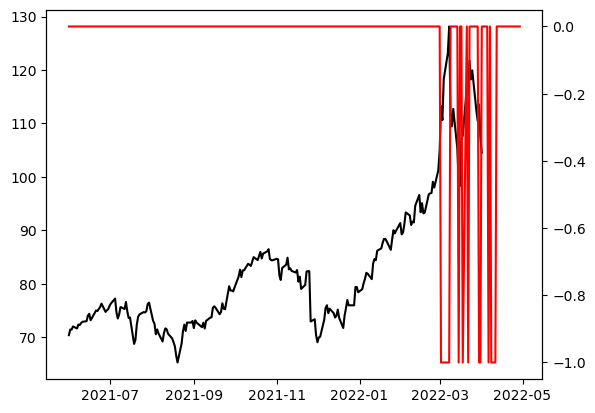

LPPL Sell Signal was active. Bubble Climax end date estimates: [Timestamp('2022-03-02 00:00:00'), Timestamp('2022-03-03 00:00:00'), Timestamp('2022-03-04 00:00:00'), Timestamp('2022-03-07 00:00:00'), Timestamp('2022-03-08 00:00:00'), Timestamp('2022-03-15 00:00:00'), Timestamp('2022-03-18 00:00:00'), Timestamp('2022-03-22 00:00:00'), Timestamp('2022-03-30 00:00:00'), Timestamp('2022-03-31 00:00:00'), Timestamp('2022-04-06 00:00:00'), Timestamp('2022-04-08 00:00:00'), Timestamp('2022-04-11 00:00:00')]
No buy signals


In [3]:
df = output.loc['2021-06-01':'2022-05-01']

plt.plot(df.price, color="black")
plt.twinx().plot(df.signal, color="red")
plt.show()

buys = df.query("signal > 0")
sells = df.query("signal < 0")

if sells.shape[0] > 0:
    print(f"LPPL Sell Signal was active. Bubble Climax end date estimates: {sells.index.to_list()}")
else:
    print("No sell signals")

if buys.shape[0] > 0:
    print(f"LPPL Buy Signal was active. Crash Climax end date estimates: {buys.index.to_list()}")
else:
    print("No buy signals")

